# Statistical Analysis of the *La Permanence* dataset

This notebook follows [Yury Kashnitskiy's course](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python) on time series analysis.

## Imports

In [134]:
import datetime
import os
import itertools
import pytz
import numpy as np
import sklearn.metrics
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [47]:
nb_minutes = 10
FREQ = f'{nb_minutes}T'
DAY = (60//nb_minutes)*24 # if FREQ is 10 minutes
tz_utc = pytz.timezone("UTC")
tz_paris = pytz.timezone("Europe/Paris")
days_of_the_week = {0: 'Mo', 1: 'Tu', 2: 'We', 3: 'Th', 4: 'Fr', 5: 'Sa', 6: 'Su'}

## Load data

In [5]:
dwnld_beg = datetime.datetime.now()
datafile = 'attendance.csv'
filepath = os.path.join(os.path.expanduser("~"), 'Projects/la_permanence', datafile)
filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=',')
dwnld_end = datetime.datetime.now()
print("Data loaded in {0} sec.".format((dwnld_end - dwnld_beg).seconds))
print("Shape of dataframe: {0}.".format(raw_data.shape))

Size of data file: 360KB.
Loading data...
Data loaded in 0 sec.
Shape of dataframe: (13941, 3).


In [10]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13941 entries, 0 to 13940
Data columns (total 3 columns):
timestamp    13941 non-null object
Moulin       13941 non-null int64
Alésia       13941 non-null int64
dtypes: int64(2), object(1)
memory usage: 326.8+ KB


## Preprocessing

Select the data for the coworking space on *rue du Fer à Moulin* and make some adjustments:

In [19]:
moulin = raw_data[['timestamp', 'Moulin']].copy()
moulin.columns = ['timestamp', 'seats']
moulin['timestamp'] = moulin['timestamp'].apply(
    lambda s: pd.Timestamp(
        *tuple(map(int, s.split("-")))
    )
)
moulin['timestamp'] = moulin['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))
moulin.set_index("timestamp", inplace=True)


In [18]:
moulin.head()

,seats
timestamp,
2019-01-08 15:49:06+01:00,4
2019-01-08 15:52:00+01:00,4
2019-01-08 15:53:00+01:00,4
2019-01-08 15:54:00+01:00,4
2019-01-08 15:55:01+01:00,4


Data was not collected at regular times, perform time regularization:

In [23]:
moulin = moulin.resample(FREQ).mean().interpolate()
moulin = moulin.asfreq(FREQ)

Plot timeseries:

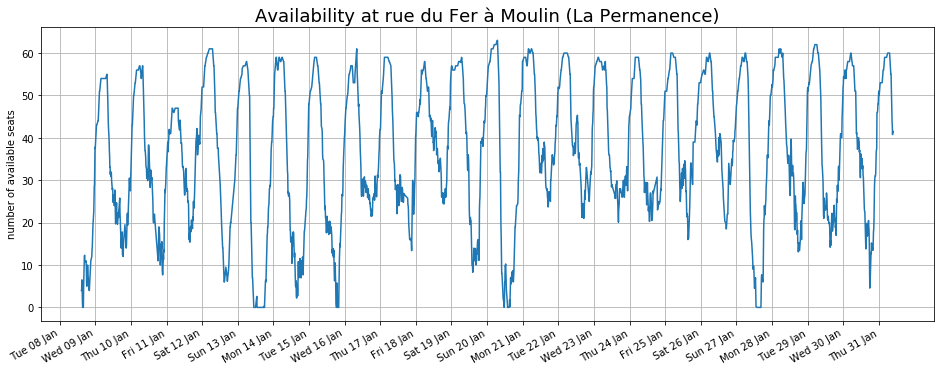

In [57]:
fig, ax = plt.subplots(figsize=(16, 6));
moulin.plot(ax=ax);
plt.ylabel("number of available seats");
ax.axes.get_xaxis().label.set_visible(False);
plt.title("Availability at rue du Fer à Moulin (La Permanence)", fontsize=18)
ax.get_legend().remove()
ts_min = moulin.index.min()
ts_max = moulin.index.max()
moulin_date_range = pd.date_range(ts_min.date(), ts_max.date());
ax.set_xticks(moulin_date_range)
ax.set_xticklabels([pd.to_datetime(pandas_datetime).strftime("%a %d %b") for pandas_datetime in moulin_date_range]);
plt.grid()
#plt.savefig('La-Permanence-moulin.png')

In [132]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False, figsize=(16, 6)):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    fig, ax = plt.subplots(figsize=figsize)
    rolling_mean.plot(ax=ax, style='g', label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = sklearn.metrics.mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        ax.plot(upper_bound, "r--", label="Upper bound / Lower bound")
        ax.plot(lower_bound, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            ax.plot(anomalies, "ro", markersize=10)
     
    series[window:].plot(ax=ax)
    
    ax.set_title("Moving average\n window size = {} day(s)".format(window//DAY))
    ts_min = series[window:].index.min()
    ts_max = series[window:].index.max()
    series_date_range = pd.date_range(ts_min.date(), ts_max.date());
    ax.set_xticks(series_date_range)
    ax.set_xticklabels([pd.to_datetime(pandas_datetime).strftime("%a %d %b") for pandas_datetime in series_date_range]);
    ax.legend(['Rolling mean trend', 'Actual values'])
    ax.grid(True)

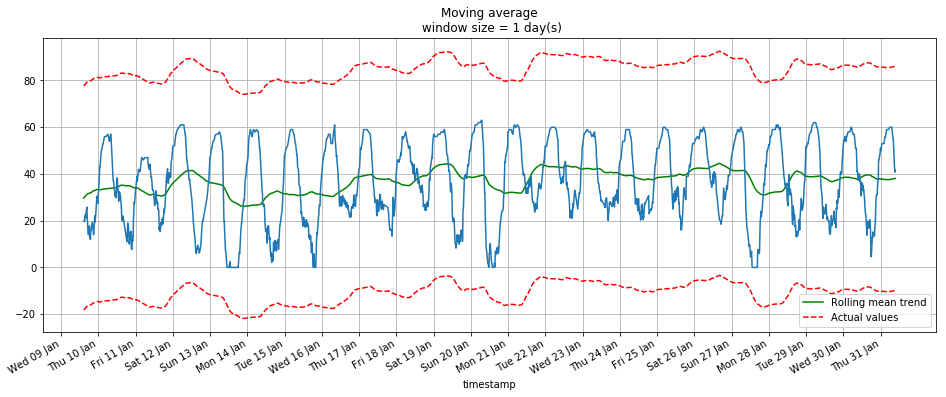

In [133]:
plotMovingAverage(moulin, DAY, plot_intervals=True, plot_anomalies=True)

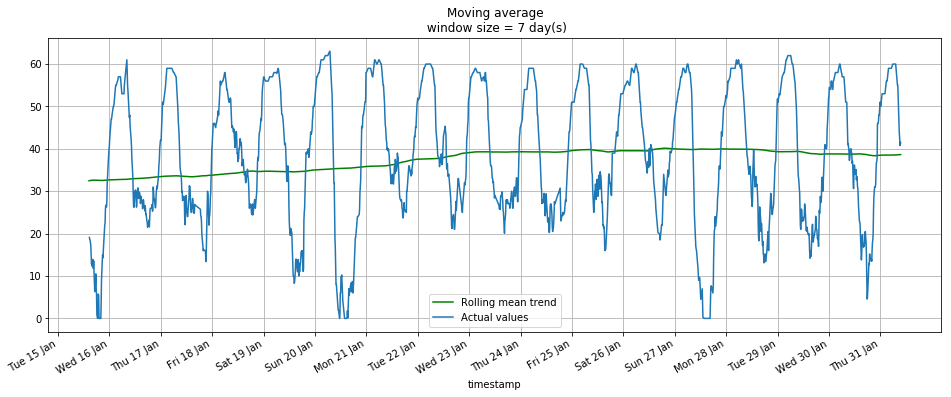

In [88]:
plotMovingAverage(moulin, 7*DAY)

In [38]:
#plotMovingAverage(moulin, 24, plot_intervals=True)

In [39]:
#plotMovingAverage(moulin, 24, plot_intervals=True, plot_anomalies=True)

In [ ]:
attendance = raw_data.copy()

attendance['timestamp'] = attendance['timestamp'].apply(
    lambda s: pd.Timestamp(
        *tuple(map(int, s.split("-")))
    )
)
attendance['timestamp'] = attendance['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))


In [ ]:
attendance.head()

Set `timestamp` to index:

In [ ]:
attendance.set_index("timestamp", inplace=True)

In [ ]:
attendance.head()

Time regularization:

In [ ]:
attendance = attendance.resample(FREQ).mean().interpolate()

In [ ]:
attendance.head()

Set `freq`: 

In [ ]:
attendance = attendance.asfreq(FREQ)

In [ ]:
#attendance.index

In [ ]:
attendance.head()

In [ ]:
attendance.diff().plot(figsize=(16, 6));

In [ ]:
attendance.diff().corr()

In [ ]:
attendance.rolling(DAY).mean().plot(figsize=(16, 6));

In [ ]:
attendance.rolling(3*DAY).mean().plot(figsize=(16, 6));

In [ ]:
#attendance.rolling(DAY_SEASONALITY).mean().plot(x='Moulin', y='Alésia', kind="scatter", style=".", figsize=(16, 6));

In [ ]:
attendance.rolling(7*DAY).mean().plot(figsize=(16, 6));

In [ ]:
#attendance.rolling(WEEK_SEASONALITY).mean().plot(x='Moulin', y='Alésia', kind="scatter", style=".", figsize=(4, 4));

# Extract data for location at *rue du Fer à Moulin*

In [ ]:
values = attendance['Moulin'].values
#idx = pd.Index(attendance['timestamp'])
idx = pd.DatetimeIndex(attendance.index)
moulin = pd.Series(values, index=idx)
moulin.iloc[-10:]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6));
moulin.plot(ax=ax, style='-o', **{"markersize": 1, "markerfacecolor": "k", "markeredgecolor": "k"});
plt.ylabel("number of available seats");
plt.title('Attendance at the rue du Fer à Moulin location')
ax.legend().remove()

# Seasonal decomposition

### One-day seasonality

In [ ]:
day_decomposition = sm.tsa.seasonal_decompose(moulin, model='additive', freq=DAY_SEASONALITY)

In [ ]:
#fig, ax = plt.subplots(figsize=(16, 6));
#day_decomposition.plot();

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8));
day_decomposition.trend.plot(ax=ax1);
day_decomposition.resid.plot(ax=ax2);
day_decomposition.seasonal.plot(ax=ax3);

### One-week seasonality

In [ ]:
week_decomposition = sm.tsa.seasonal_decompose(moulin, model='additive', freq=WEEK_SEASONALITY)

In [ ]:
#fig, ax = plt.subplots(figsize=(16, 6));
#week_decomposition.plot();

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8));
week_decomposition.trend.plot(ax=ax1);
week_decomposition.resid.plot(ax=ax2);
week_decomposition.seasonal.plot(ax=ax3);

# Autocorrelation

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6));
pd.plotting.autocorrelation_plot(moulin, ax=ax);

In [ ]:
len(moulin)